Nodal Galerkin method for curved quadrilaterals

In [46]:
import numpy as np
from numpy import pi, cos, sin, log, sqrt

import matplotlib.pyplot as plt
from matplotlib import cm

# Reloading the module
import importlib

import Nodal2D
importlib.reload(Nodal2D)
from Nodal2D import *

import Curve
importlib.reload(Curve)
from Curve import *

import MappingGeometry2D
importlib.reload(MappingGeometry2D)
from MappingGeometry2D import *

import Potential2D
importlib.reload(Potential2D)
from Potential2D import *

## Boundary curves

In [47]:
# Four corner points
x1 = np.array([-1,-1])
x2 = np.array([1,0])
x3 = np.array([0,1])
x4 = np.array([-1,1])

In [48]:
# Creating curve1
# Create a curve class
c1 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c1.set_parameter_points(point_type="Legendre")
c1.set_BarycentricWeights()
c1.set_DiffMatrix()

c1.set_end_points_straight(point_start=x1, point_end=x2)
c1.cal_coordinates_node_straight()
c1.cal_derivatives_node_straight()

In [49]:
# Creating curve2
# Create a curve class
c2 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c2.set_parameter_points(point_type="Chebyshev")
c2.set_BarycentricWeights()
c2.set_DiffMatrix()

# Parameter range
par_range = np.array([0, pi/2])



def x(t):
    return 1 - sin(t)

def y(t):
    return 1 - cos(t)

def x_deri(t):
    return -cos(t)

def y_deri(t):
    return sin(t)

c2.reparameterization(x, y, x_deri, y_deri, par_range)
c2.cal_derivatives_node()

In [50]:
# Creating curve3
# Create a curve class
c3 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c3.set_parameter_points(point_type="Legendre")
c3.set_BarycentricWeights()
c3.set_DiffMatrix()

c3.set_end_points_straight(point_start=x4, point_end=x3)
c3.cal_coordinates_node_straight()
c3.cal_derivatives_node_straight()

In [51]:
# Creating curve4
# Create a curve class
c4 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c4.set_parameter_points(point_type="Legendre")
c4.set_BarycentricWeights()
c4.set_DiffMatrix()

c4.set_end_points_straight(point_start=x1, point_end=x4)
c4.cal_coordinates_node_straight()
c4.cal_derivatives_node_straight()

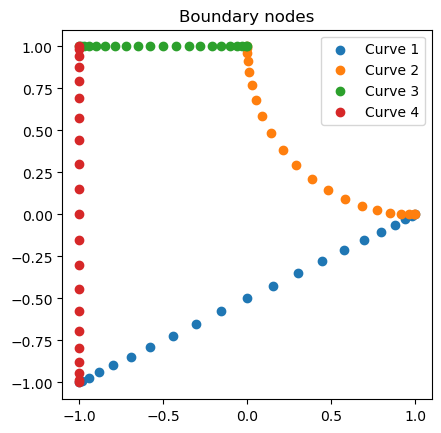

In [52]:
# Collecting the boundary curves
curves = [c1, c2, c3, c4]

# Testing the geometry
fig, ax = plt.subplots(nrows=1, ncols=1)
for i, c in enumerate(curves):
    ax.scatter(c.x_nodes, c.y_nodes, label='Curve {}'.format(i+1))
ax.legend()
ax.set_title('Boundary nodes')
ax.set_aspect('equal')

## Nodes

In [53]:
N = 22
M = 20
nodal2D = Nodal2D(N,M)
nodal2D.cal_nodes(node_type_x="Legendre", node_type_y="Legendre")
nodal2D.cal_BarycentricWeights()
nodal2D.cal_DiffMatrix()

## Mapping

In [54]:
# Initialize the mapping
mg = MappingGeometry2D(nodal2D=nodal2D, curves=curves)
# Calculating the physical nodes
mg.cal_Map_nodes()
# Calculating the node derivatives
mg.cal_MapDerivatives_nodes()
# Calculating the node Jacobian
mg.cal_Jacobian()
# Calculating the normal vectors on the boundary
mg.cal_normal_vector_nodes()

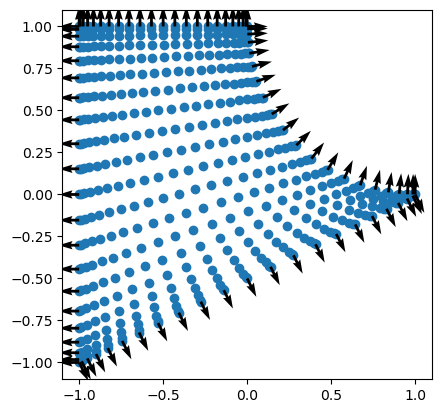

In [55]:
# Visualizing the nodes and the normal vectors
fig, ax = plt.subplots(nrows=1, ncols=1)
Nx = mg.nodal2D.Nx
Ny = mg.nodal2D.Ny

ax.scatter(mg.nodes_phy_x, mg.nodes_phy_y)

j = 0
ax.quiver(mg.nodes_phy_x[:,j], mg.nodes_phy_y[:,j], 
              mg.norm_vect_lower[:,0], mg.norm_vect_lower[:,1])
    
j = Ny   
ax.quiver(mg.nodes_phy_x[:,j], mg.nodes_phy_y[:,j], 
              mg.norm_vect_upper[:,0], mg.norm_vect_upper[:,1])    

i = 0
ax.quiver(mg.nodes_phy_x[i,:], mg.nodes_phy_y[i,:], 
              mg.norm_vect_left[:,0], mg.norm_vect_left[:,1])

i = Nx
ax.quiver(mg.nodes_phy_x[i,:], mg.nodes_phy_y[i,:], 
              mg.norm_vect_right[:,0], mg.norm_vect_right[:,1])   

ax.set_aspect('equal')

## Solving the system

Text(0.5, 0.92, 'BC')

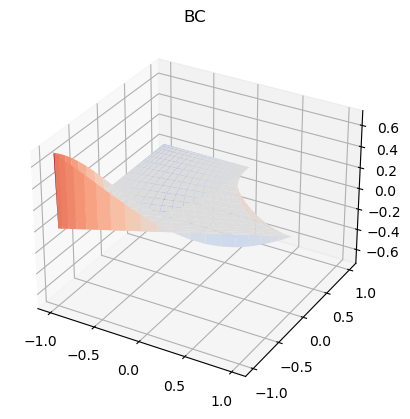

In [56]:
# Compute the source terms
# The exact solution 
U_th = np.sin(mg.nodes_phy_x) * np.sin(mg.nodes_phy_y) 
# Source term
S = -2 * np.sin(mg.nodes_phy_x) * np.sin(mg.nodes_phy_y) 
# Initializing the solution matrix
# The boundary values are set and inner values are zeros.
U = np.sin(mg.nodes_phy_x) * np.sin(mg.nodes_phy_y) 
U[1:mg.nodal2D.Nx, 1:mg.nodal2D.Ny] = 0.0
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})
ax.plot_surface(mg.nodes_phy_x, mg.nodes_phy_y, U, cmap=cm.coolwarm)
ax.set_title("BC")

In [57]:
# Preparing coefficients
coeff_xi = (mg.X_xi**2 + mg.Y_xi**2) / mg.J
coeff_eta = (mg.X_eta**2 + mg.Y_eta**2) / mg.J
coeff_mixed = (mg.X_xi * mg.X_eta + mg.Y_xi * mg.Y_eta) / mg.J
# Constructing RHS
RHS = cal_RHS_Nonsquare_NodalGalerkin_Dirichlet(U=U, 
                                                S=S, 
                                                J=mg.J, 
                                                w_xi=mg.nodal2D.w_GL_x, 
                                                w_eta=mg.nodal2D.w_GL_y, 
                                                D_xi=mg.nodal2D.Dx, 
                                                D_eta=mg.nodal2D.Dy, 
                                                coeff_xi=coeff_xi, 
                                                coeff_eta=coeff_eta, 
                                                coeff_mixed=coeff_mixed, 
                                                N=mg.nodal2D.Nx, 
                                                M=mg.nodal2D.Ny)


# Constructing the extended system: Cx = d
C, d = MatEqnConverter_Nonsquare_NodalGalerkin_Dirichlet(w_xi=mg.nodal2D.w_GL_x, 
                                                         w_eta=mg.nodal2D.w_GL_y, 
                                                         D_xi=mg.nodal2D.Dx, 
                                                         D_eta=mg.nodal2D.Dy, 
                                                         coeff_xi=coeff_xi, 
                                                         coeff_eta=coeff_eta, 
                                                         coeff_mixed=coeff_mixed, 
                                                         N=mg.nodal2D.Nx, 
                                                         M=mg.nodal2D.Ny, 
                                                         RHS=RHS)

In [58]:
# Solving the system
U[1:mg.nodal2D.Nx, 1:mg.nodal2D.Ny] =MatEqnSolver_Cxd(C=C, d=d, N=mg.nodal2D.Nx, M=mg.nodal2D.Ny)
# Comparing with the exact solution
# The exact solution is u = x^2 + y^2
print("Error:", np.max(np.abs(U-U_th)))

Error: 9.356218577671882e-11


Text(0.5, 0.92, 'Theretical')

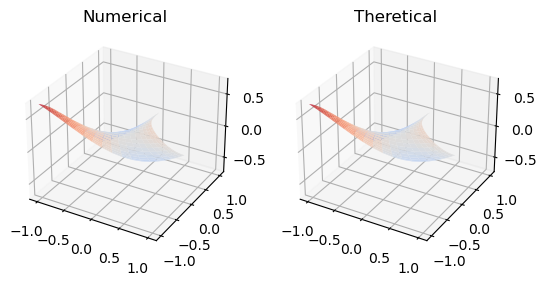

In [59]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})
ax[0].plot_surface(mg.nodes_phy_x, mg.nodes_phy_y, U, cmap=cm.coolwarm)
ax[1].plot_surface(mg.nodes_phy_x, mg.nodes_phy_y, U_th, cmap=cm.coolwarm)

ax[0].set_title("Numerical")
ax[1].set_title("Theretical")

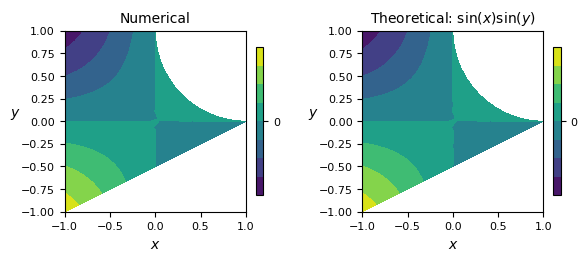

In [60]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2)
ct_numerical = ax[0].contourf(mg.nodes_phy_x, mg.nodes_phy_y, U)
ct_th = ax[1].contourf(mg.nodes_phy_x, mg.nodes_phy_y, U_th)


# Colorbars
# Calculate ratio to adjust the colorbar size
ct_ratio = mg.nodal2D.Nx / mg.nodal2D.Ny
cb_numerical = fig.colorbar(ct_numerical, ax=ax[0], fraction=0.034*ct_ratio, ticks=[0, 8, 16])
cb_th = fig.colorbar(ct_th, ax=ax[1], fraction=0.034*ct_ratio, ticks=[0, 8, 16])
# Change the tick label size
cb_tick_label_size = 8
cb_numerical.ax.tick_params(labelsize=cb_tick_label_size)
cb_th.ax.tick_params(labelsize=cb_tick_label_size)

# x,y labels
label_size = 10
for i in range(2):
    ax[i].set_xlabel(r'$x$', fontsize=label_size)
    ax[i].set_ylabel(r'$y$', rotation=0, fontsize=label_size)
    
# Tick labels
tick_label_size = 8
for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=tick_label_size)
    ax[i].tick_params(axis='both', which='minor', labelsize=tick_label_size)

# Titles
title_size = 10
ax[0].set_title("Numerical", fontsize=title_size)
ax[1].set_title("Theoretical: "+r'$\sin(x)\sin(y)$', fontsize=title_size)


# Shape adjustment
# Aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# Hozirontal spacing
fig.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing

# Save figure
filename = "./2D_Potential_Nonsquare_NodalGalerkin/curved_domain_.jpg"
fig.savefig(filename, dpi=600, bbox_inches="tight")